# 🚂 **Analyse du réseau ferré de la SNCF: Comment expliquer les retards permanents de la compagnie française ?** 🚂



Comme tout bon étudiant provincial du plateau de Saclay, nous avons régulièrement eu à faire aux retards interminables des trains de la SNCF. A l'heure où le train est de plus en plus destiné à remplacer l'aviation civile ultra-polluante, nous avons voulu analyser l'évolution et les causes des retards que subissent fréquemment les usagers du réseau ferré français. 

Pour cela, nous avons basé notre analyse sur différentes bases de données rendues publiques et entretenues par la SNCF elle même. Ce travail a vocation à répondre aux exigences du cours de **Python pour la Data Science** de 2ème année de l'ENSAE Paris et reprend la même articulation en 3 axes: 
- Récupération et traitement des données
- Analyse descriptive et représentation graphique
- Modélisation 

Tout au long de ce notebook, nous ferons appel à des fonctions utiles définies dans le fichier **fonctions.py**. A la fin du travail d'analyse, nous vous proposons également un petit jeu intéractif bonus à ouvrir dans un autre éditeur de code que Jupyter. 

## **1. Récupération et Traitement des données de l'API de la SNCF**

On commence par importer les librairies et les fonction définies dans le fichier **fonction.py**

In [1]:
from fonctions import *

Nous avons commencé notre travail sur le site de l'API SNCF *https://ressources.data.sncf.com/api/v2/console*. Il propose d'accéder à plus de 216 datasets qui regroupent différents types de données concernant la SNCF. Le premier fichier que nous avons étudié est le **Catalogue** qui présente tous les autres datasets disponnibles sur l'API. C'est à partir de ce Catalogue que nous avons pu identifier les différents datasets utiles à nos analyses.

In [2]:
df_catalogue = importer("https://ressources.data.sncf.com/api/v2/catalog/exports/json?limit=-1&offset=0&timezone=UTC")
pd.DataFrame(df_catalogue['dataset_id']).head(2)

,dataset_id
0,saisines-avis-mediateur-sncf
1,stocks-2017-cco


### **1.1 Analyse du réseau ferré de la SNCF**

Pour commencer notre analyse, nous avons voulu identifier les stations SNCF les plus fréquentées afin d'avoir une meilleure idée du maillage du réseau ferré français. Nous allons chercher les données qui nous interessent dans les datasets **liste_des_gares** et **frequentations_gares** disponnibles sur l'API de la SNCF.


#### **1.1.1 Importation des données**

In [3]:
#importation de la liste des gares, API SNCF
df_gares = importer("https://ressources.data.sncf.com/api/v2/catalog/datasets/liste-des-gares/exports/json?limit=-1&offset=0&timezone=UTC")
df_gares.head(2)

,code_uic,libelle,fret,voyageurs,code_ligne,rg_troncon,pk,commune,departemen,idreseau,idgaia,x_l93,y_l93,x_wgs84,y_wgs84,c_geo,geo_point_2d,geo_shape
0,87755223,Bandol,N,O,930000,1,050+607,BANDOL,VAR,3077,29a5a626-dfbc-11e3-a2ff-01a464e0362d,923833.7169,6.230702e+06,5.749816,43.140491,"{'lon': 5.749815526229215, 'lat': 43.140491048...","{'lon': 5.749815526229215, 'lat': 43.140491047...","{'type': 'Feature', 'geometry': {'coordinates'..."
1,87696179,Pouilly-sur-Loire,O,O,750000,1,214+004,POUILLY-SUR-LOIRE,NIEVRE,6141,297a4c76-dfbc-11e3-a2ff-01a464e0362d,697358.2537,6.686913e+06,2.965051,47.282528,"{'lon': 2.965051211539136, 'lat': 47.282528482...","{'lon': 2.965051211539134, 'lat': 47.282528481...","{'type': 'Feature', 'geometry': {'coordinates'..."


In [4]:
#importation des données sur la frequentation des gares, API SNCF
df_freq_gares = importer("https://ressources.data.sncf.com/api/v2/catalog/datasets/frequentation-gares/exports/json?limit=-1&offset=0&timezone=UTC")
df_freq_gares.head(2)

,nom_gare,code_uic_complet,code_postal,segmentation_drg,total_voyageurs_2021,total_voyageurs_non_voyageurs_2021,total_voyageurs_2020,total_voyageurs_non_voyageurs_2020,total_voyageurs_2019,total_voyageurs_non_voyageurs_2019,total_voyageurs_2018,total_voyageurs_non_voyageurs_2018,totalvoyageurs2017,total_voyageurs_non_voyageurs_2017,total_voyageurs_2016,total_voyageurs_non_voyageurs_2016,total_voyageurs_2015,total_voyageurs_non_voyageurs_2015
0,Abbaretz,87481614,44170,c,27466,27466,22773,22773,38473,38473,38027,38027,35637,35637,33021,33021,35989,35989
1,Aéroport Charles de Gaulle 1,87271460,93290,b,3460437,3460437,2177954,2177954,7971396,7971396,7590098,7590098,7199779,7199779,6690263,6690263,6226179,6226179


In [5]:
#comparaison du nombre de données (moins de données sur la fréquentation)
print(len(df_freq_gares))
print(len(df_gares))

2970
3819


#### **1.1.2 Constitution de la base de données (nettoyage, fusion, et concaténation de données)**

On va travailler sur les 2 datasets importés afin de créer notre base de données des gares SNCF les plus fréquentées.

In [6]:
#Harmonisation du nom de la colonne code_uic en vue du merge
df_freq_gares.rename(columns = {'code_uic_complet':'code_uic'}, inplace = True)

In [7]:
#On regarde quelles gares du dataframe "liste des gares" ne sont pas dans le dataframe "frequentations"
outer_merged = pd.merge(df_gares, df_freq_gares, how="outer", on=["code_uic"])
outer_merged[outer_merged['nom_gare'].isna()==True][['code_uic', 'libelle']].head(2)

,code_uic,libelle
3,87784488,Cases-de-Pène
12,87396671,La Chartre-sur-le-Loir


Ce ne sont que des petites gares et comme nous nous intéressons aux gares les plus fréquentées, non allons considérer seulement celles du dataset des fréquentation.

In [8]:
#Fusion des dataframes sur la base de df_freq_gares avec un left merge
left_merged = pd.merge(df_freq_gares, df_gares, how="left", on=["code_uic"])
df_gares_merged = left_merged[['code_uic','total_voyageurs_non_voyageurs_2020', 'nom_gare', 'x_wgs84','y_wgs84']]
df_gares_merged.head(2)

,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84
0,87481614,22773,Abbaretz,-1.524313,47.555462
1,87271460,2177954,Aéroport Charles de Gaulle 1,2.555964,49.008827


In [9]:
#Elimination des gares dont la frequentation est nulle
df_gares_merged = df_gares_merged.drop(df_gares_merged[df_gares_merged['total_voyageurs_non_voyageurs_2020']==0].index)

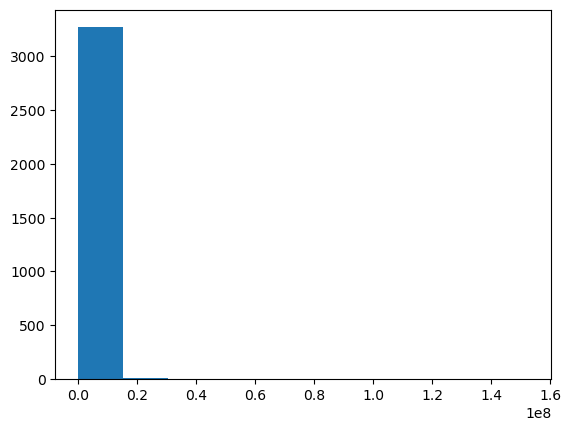

In [10]:
#Visualisation de la répartition des fréquentations par gare
plt.hist(df_gares_merged['total_voyageurs_non_voyageurs_2020'])
plt.show()

On remarque que pour mieux apprécier les fréquentations, il est nécessaire de passer au log.

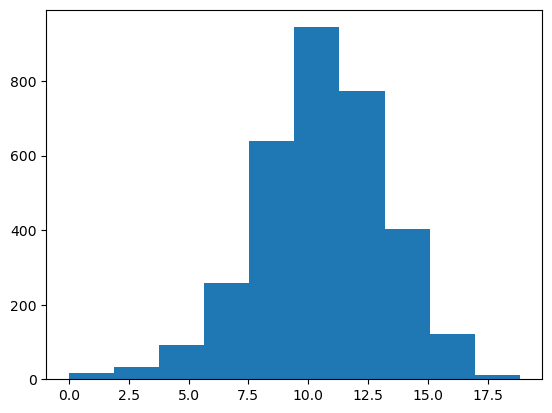

In [11]:
df_gares_merged['log_total_voyageurs_non_voyageurs_2020'] = np.log(df_gares_merged['total_voyageurs_non_voyageurs_2020'])
plt.hist(df_gares_merged['log_total_voyageurs_non_voyageurs_2020'])
plt.show()

In [12]:
#Application d'un filtre sur les frequentations : on ne garde que les gares les plus frequentées
df_gares_principales = df_gares_merged[df_gares_merged['log_total_voyageurs_non_voyageurs_2020']>= 14]

On regarde maintenant les gares très fréquentées pour lesquelles il nous manque les coordonnées GPS. A savoir, les gares qui sont des le dataset des fréquentations mais pas dans celui de la liste des gares.

In [13]:
df_gares_manquantes  = df_gares_principales[df_gares_principales['x_wgs84'].isna()==True]
df_gares_manquantes.head(2)

,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84,log_total_voyageurs_non_voyageurs_2020
384,87756403,4085871,Monaco-Monte-Carlo,NaN,NaN,15.223045
664,87113795,3664906,Villiers-sur-Marne - Le Plessis-Trévise,NaN,NaN,15.114313


- **Problème** : il nous manque les données GPS de gares importantes (la gare de Paris EST par exemple)
- **Solution** : ces gares étant -presque- toutes situées en région Ile de France (idf) on va aller chercher ces données sur l'API de la région idf.

On sort donc les données manquantes de ce dataframe et on va aller les chercher sur l'API idf (il nous manquera tout de même la gare de Monaco mais nous allons l'omettre car il ne s'agit que d'une gare et que Monaco n'est pas en France à proprement parlé).

In [14]:
#Elimination des gares dont on ne connait pas la fréquentation
df_gares_principales = df_gares_principales[df_gares_principales['x_wgs84'].isna()==False]
df_gares_principales.head(2)

,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84,log_total_voyageurs_non_voyageurs_2020
1,87271460,2177954,Aéroport Charles de Gaulle 1,2.555964,49.008827,14.593896
7,87741132,1236162,Aix-les-Bains le Revard,5.908901,45.688112,14.027522


In [15]:
#Récupération des données manquantes (sauf Monaco) grâce à l'API de la région idf
df_region_idf_initial = importer("https://data.iledefrance.fr/api/v2/catalog/datasets/gares-et-points-darrets-du-reseau-transilien/exports/json?limit=-1&offset=0&timezone=UTC")

#On se restreint aux gares dont les données geographiques sont manquantes dans le dataframe des gares principales
df_region_idf = df_region_idf_initial[df_region_idf_initial.code_uic.isin(df_gares_manquantes['code_uic'])==True]
df_region_idf.head(2)

,code_uic,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,nom_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf
62,87113209,871132,PANTIN,PANTIN,GARE DE PANTIN,Pantin,Pantin,Avenue de la gare 93500 Pantin,93055,[Pantin],604688.0,2433279.0,"{'lon': 2.40040674765, 'lat': 48.8977738494}",2.0,0.0
166,87116038,871160,ROISSY EN BRIE,ROISSY EN BRIE,GARE DE ROISSY EN BRIE,Roissy en B.,Roissy-en-Brie,Place de la gare 77680 Roissy-en-Brie,77390,[Roissy-en-Brie],623033.0,2421933.0,"{'lon': 2.64984936854, 'lat': 48.7954076773}",5.0,0.0


**Remarque :** il nous manque encore la gare du Nord. En allant chercher manuellement la ligne correspondante, on remarque que c'est parce que le code uic est erroné (le code uic est différent dans les 2 bases). Après recherches, le vrai code uic est celui de la base idf. On le rectifie manuellement.

In [16]:
#Mise en évidence de l'erreur
print(df_region_idf_initial[df_region_idf_initial['libelle']=="PARIS NORD"][['libelle', 'code_uic']])
print(df_gares_manquantes[df_gares_manquantes['nom_gare']== "Paris Gare du Nord"][['nom_gare', 'code_uic']])

       libelle  code_uic
92  PARIS NORD  87271031
                nom_gare  code_uic
1112  Paris Gare du Nord  87758904


In [17]:
#Rectification de l'erreur, puis réiteration de l'opération qui récupère uniquement les gares manquantes
df_gares_manquantes.loc[df_gares_manquantes['nom_gare']=="Paris Gare du Nord", "code_uic"] = "87271031"
df_region_idf = df_region_idf_initial[df_region_idf_initial.code_uic.isin(df_gares_manquantes['code_uic'])==True]

#Pour simplifier, reset de l'index
df_region_idf.reset_index(inplace = True)
df_region_idf = df_region_idf.drop('index', axis=1)
df_region_idf.head(2)

,code_uic,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,nom_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf
0,87113209,871132,PANTIN,PANTIN,GARE DE PANTIN,Pantin,Pantin,Avenue de la gare 93500 Pantin,93055,[Pantin],604688.0,2433279.0,"{'lon': 2.40040674765, 'lat': 48.8977738494}",2.0,0.0
1,87271031,872710,PARIS NORD (GARE DU NORD),PARIS NORD,GARE DU NORD SURFACE,Gare du Nord,Gare du Nord Surface,None,75110,[Paris],601529.0,2431239.0,"{'lon': 2.35733955798, 'lat': 48.8794550008}",1.0,0.0


In [18]:
#Récuperation des donnees gps pour la nouvelle base de donnees : séparation des données géographiques en 2 colonnes (latitude et longitude)
df_region_idf['x_wgs84'] = [0]*len(df_region_idf)
df_region_idf['y_wgs84'] = [0]*len(df_region_idf)

for i in range(len(df_region_idf)):
    df_region_idf.loc[i,'x_wgs84'] = df_region_idf['coord_gps_wgs84'][i]['lon']
    df_region_idf.loc[i,'y_wgs84'] = df_region_idf['coord_gps_wgs84'][i]['lat']
    
df_region_idf.head(2)

,code_uic,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,nom_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf,x_wgs84,y_wgs84
0,87113209,871132,PANTIN,PANTIN,GARE DE PANTIN,Pantin,Pantin,Avenue de la gare 93500 Pantin,93055,[Pantin],604688.0,2433279.0,"{'lon': 2.40040674765, 'lat': 48.8977738494}",2.0,0.0,2.400407,48.897774
1,87271031,872710,PARIS NORD (GARE DU NORD),PARIS NORD,GARE DU NORD SURFACE,Gare du Nord,Gare du Nord Surface,None,75110,[Paris],601529.0,2431239.0,"{'lon': 2.35733955798, 'lat': 48.8794550008}",1.0,0.0,2.357340,48.879455


In [19]:
#Enfin, concaténation des dataframes venant de l'API SNCF et de l'API région IDF
df_complete_gares = pd.concat([df_gares_principales, df_region_idf], ignore_index = True)
df_complete_gares.head(2)

,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84,log_total_voyageurs_non_voyageurs_2020,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf
0,87271460,2177954.0,Aéroport Charles de Gaulle 1,2.555964,49.008827,14.593896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,87741132,1236162.0,Aix-les-Bains le Revard,5.908901,45.688112,14.027522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On finit, après pas mal d'ajustements, par obtenir le dataset souhaité des gares les plus fréquentées ainsi que leurs coordonnées GPS. On s'en reservira plus tard dans la partie Visualisation et Représentation Gprahique de ce travail.

### **1.2 Analyse des retards et des annulations de trains de la SNCF**

Pour cette partie, on travaille exclusivement sur le dataset **regularite-mensuelle-tgv-aqst** qui contient l'ensemble des données sur les retards et les annulations des lignes de TGV gérées par la SNCF. On commence par importer et nettoyer les données.

In [20]:
df_retards = importer('https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC')
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,BREST,PARIS MONTPARNASSE,225,284,3,None,4,2.250000,...,19,5.370390,5,2,33.333333,53.333333,0.000000,13.333333,0.000000,0.0
1,2018-01,National,PARIS MONTPARNASSE,ANGOULEME,126,239,4,None,36,6.347685,...,15,4.113191,3,0,15.384615,38.461538,19.230769,23.076923,3.846154,0.0


In [21]:
#on retire les colonnes de commentaires qui sont generalement vides
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)

In [22]:
#on retire aussi les colonnes de NaN et dont les retards valent 0 qui ne nous interessent pas ici
df_retards.dropna(inplace = True)
df_retards = df_retards.drop(df_retards[df_retards['retard_moyen_arrivee']==0].index)

In [23]:
#on copie la dataframe initiale par securite
df_retards_initial = df_retards.copy()

On crée ensuite les colonnes susceptibles de nous interesser par la suite.

In [24]:
df_retards['prct_nb_train_depart_retard'] = df_retards['nb_train_depart_retard']/df_retards['nb_train_prevu']*100
df_retards['prct_nb_annulation'] = df_retards['nb_annulation']/df_retards['nb_train_prevu']*100
df_retards['cause_materiel_roulant'] = df_retards['prct_cause_materiel_roulant']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_infra'] = df_retards['prct_cause_infra']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_gestion_trafic'] = df_retards['prct_cause_gestion_trafic']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_externe'] = df_retards['prct_cause_externe']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_gestion_gare'] = df_retards['prct_cause_gestion_gare']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_prise_en_charge_voyageurs'] = df_retards['prct_cause_prise_en_charge_voyageurs']/100*df_retards['nb_train_retard_arrivee']

In [25]:
#On enlève les valeurs infini possibles dans les colonnes crées et on sépare la date en 2 colonnes distinctes selon le mois et l'année
df_retards[df_retards['prct_nb_train_depart_retard'] == np.inf] = 0
df_retards[df_retards['prct_nb_annulation'] == np.inf] = 0
df_retards[['annee','mois']]=df_retards.date.str.split('-',expand=True)
df_retards['annee'] = pd.to_numeric(df_retards['annee'])
df_retards['mois'] = pd.to_numeric(df_retards['mois'])

## **2. Analyse Descriptive et Représentation Graphique**

Dans cette partie, on se concentre sur des analyses statistiques des données qui nous intéressent et leurs représentation graphique. Cela nous permet de tirer les premières conclusions quant à l'état et l'évolution du réseau ferré français et de la fréquence des perturbations qu'il subit.

### **2.1 Représentation du réseau ferré de la SNCF**

On va simplement utiliser le dataset crée dans la **partie 1.1** de la **partie 1.** afin de représenter les principales gares de la SNCF (en terme de fréquentation) sur une carte intérractive.

In [26]:
#Visualisation de la map des gares sur le territoire français avec une carte intéractive

m = folium.Map(location=[45.8666, 2.3333], min_zoom=3, max_zoom=14, zoom_start=5.3, tiles = 'Stamen Terrain')
#affichage des gares principales dont on avait les donnees gps par l'API SNCF
for i in df_complete_gares.index:
    tooltip = df_complete_gares['nom_gare'][i]
    folium.Marker([df_complete_gares['y_wgs84'][i],df_complete_gares['x_wgs84'][i]], popup=df_complete_gares['nom_gare'][i], tooltip=tooltip).add_to(m)

m

### **2.2 Analyse statistique des taux de retards et d'annulations des trains de la SNCF**

Dans cette partie, comme dans la dernière partie dédiée à la modélisation, on utilise les données sur les retards des TGV précedemment traitées.

#### **2.2.1 Analyse de l'évolution et de l'effet de substitution des taux de retard et d'annulation**

Dans cette partie, on va s'intéresser à l'évolution des taux de retard et d'annulation des TGV de la SNCF depuis 2018. On va regulièrement faire appel à la fonction **aggreg_mensuel** qui permet de renvoyer la liste à 12 éléments (pour chaque mois) d'une donnée numérique (du dataset df_retards défini plus haut) par année. On commence par analyser les taux de retard.

NameError: name 'aggreg_mensuel' is not defined

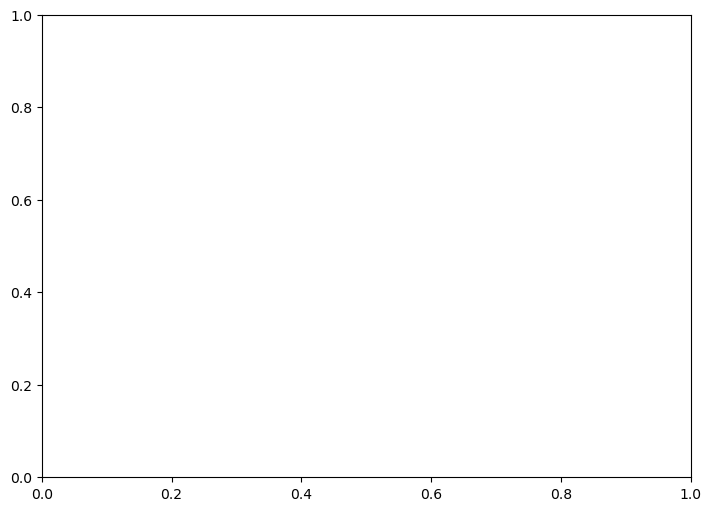

In [27]:
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
#On trace la courbe pour chaque année renseignée dans le dataset
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_train_depart_retard',2022), label=': 2022')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_train_depart_retard',2021), label=': 2021')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_train_depart_retard',2020), label=': 2020')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_train_depart_retard',2019), label=': 2019')
ax.plot(aggreg_mensuel(df_retards, 'prct_nb_train_depart_retard',2018), label=': 2018')
ax.set_xlabel('Mois')  
ax.set_ylabel('Pourcentage de trains retardés %') 
ax.set_title("Taux de retard des trains par mois")  
ax.legend()
plt.show()

On remarque une tendance à la baisse des retards entre Février et Avril suivi d'une remontée jusqu'en Juin. Par ailleurs, les années 2019 et 2020 ont été particulièrement pénible au niveau des retards. Pour essayer de mettre mieux en valeur les phénomènes décris, on va plutôt tracer la courbe étalée sur l'entièreté de la période.

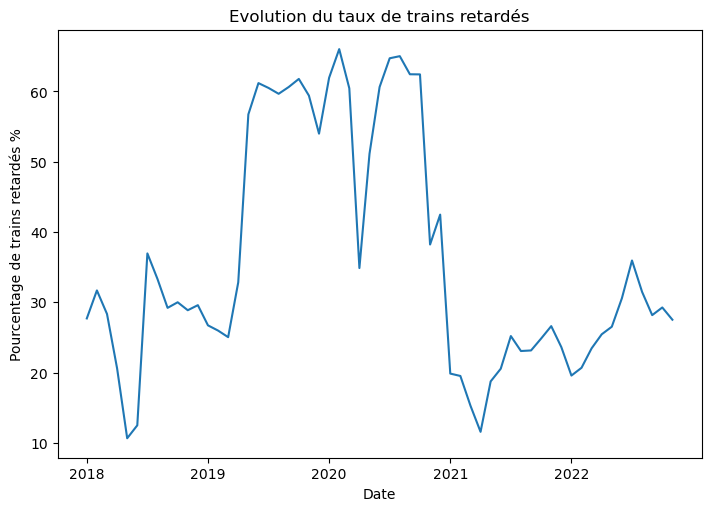

In [30]:
R = aggreg_mensuel('prct_nb_train_depart_retard',2018) + aggreg_mensuel('prct_nb_train_depart_retard',2019) + aggreg_mensuel('prct_nb_train_depart_retard',2020) + aggreg_mensuel('prct_nb_train_depart_retard',2021) + aggreg_mensuel('prct_nb_train_depart_retard',2022)
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(R)
ax.set_xlabel('Date')  
ax.set_ylabel('Pourcentage de trains retardés %') 
ax.set_title("Evolution du taux de trains retardés")
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

On observe encore mieux l'effet cyclique des retards des trains. Au début de chaque nouvelle année, on observe une diminuation du pourcentage de trains en retards suivi d'une remonté à partir de la fin du premier tier de l'année. 

Maintenant, il serait intéressant de comparer le taux de retard avec le taux d'annulation pour voir si une baisse du taux de retard est en fait compensé par une augmentation du taux d'annulation. On repète le même procédé pour avoir la courbe des taux d'annulation mensuels.

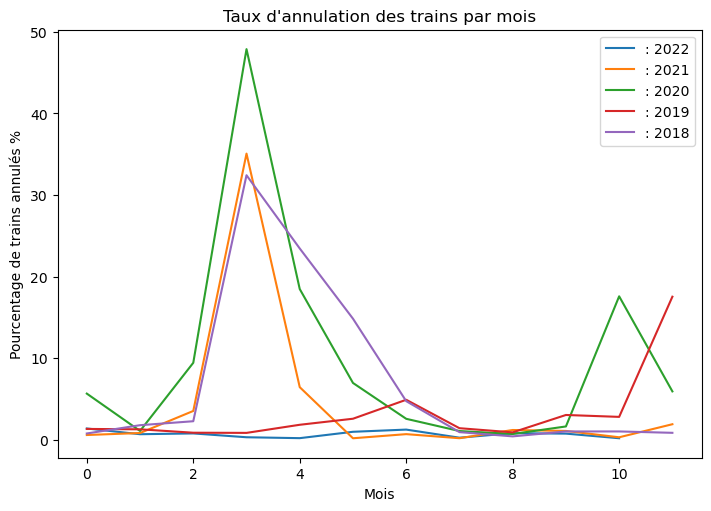

In [32]:
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(aggreg_mensuel('prct_nb_annulation',2022), label=': 2022')
ax.plot(aggreg_mensuel('prct_nb_annulation',2021), label=': 2021')
ax.plot(aggreg_mensuel('prct_nb_annulation',2020), label=': 2020')
ax.plot(aggreg_mensuel('prct_nb_annulation',2019), label=': 2019')
ax.plot(aggreg_mensuel('prct_nb_annulation',2018), label=': 2018')
ax.set_xlabel('Mois')  
ax.set_ylabel('Pourcentage de trains annulés %') 
ax.set_title("Taux d\'annulation des trains par mois")  
ax.legend()
plt.show()   

Ici, on voit clairement qu'entre février et avril, il y a un pic du nombre d'annulation des trains. On affiche la courbe étalée sur toute la période pour rendre le phénomène encore un peu plus lisible.


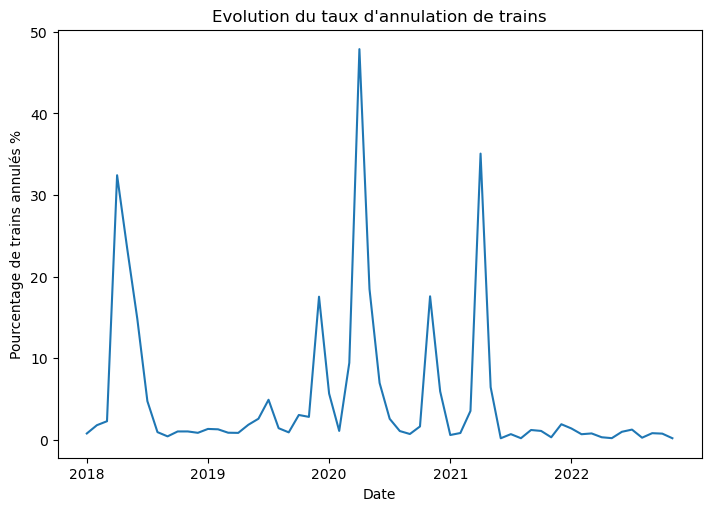

In [31]:
A = aggreg_mensuel('prct_nb_annulation',2018) + aggreg_mensuel('prct_nb_annulation',2019) + aggreg_mensuel('prct_nb_annulation',2020) + aggreg_mensuel('prct_nb_annulation',2021) + aggreg_mensuel('prct_nb_annulation',2022)
fig, ax = plt.subplots(figsize=(7, 5), layout='constrained')
ax.plot(A)
ax.set_xlabel('Date')  
ax.set_ylabel('Pourcentage de trains annulés %') 
ax.set_title("Evolution du taux d\'annulation de trains")
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

C'est encore plus clair ici, en 2018, 2020 et 2021 on observe le même pic d'annulation en début d'année. Cela correspond ou même moment où on observait une baisse du taux de trains retardés. On peut donc afficher sur le même graphe l'évolution du taux d'annulation et de retard pour mettre en avant ce phénomène.

Pour finir cette première partie, on peut rassembler les 2 métriques sur un même graphique pour illustrter de façon convaincante l'effet de substitution entre les retards et les annulations de la SNCF.

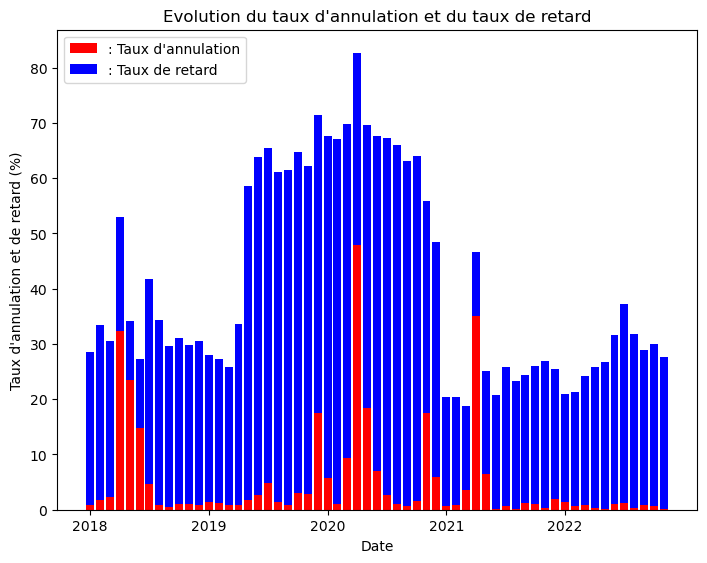

In [33]:
ind = np.arange(len(A)) 
width = 0.8
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, A, width, color='r')
ax.bar(ind, R, width,bottom=A, color='b')
ax.set_ylabel('Taux d\'annulation et de retard (%)')
ax.set_xlabel('Date')
ax.set_title('Evolution du taux d\'annulation et du taux de retard')
ax.legend(labels=[': Taux d\'annulation', ': Taux de retard'])
plt.xticks([0,12,24,36,48],['2018', '2019', '2020', '2021', '2022'])
plt.show()

#### **2.2.1 Analyse de l'évolution des causes de retard**